# Analisis de datos - Grupo 7 - Trabajo práctico - parte 2
**Inteligencia Artificial - CEIA - FIUBA - 2025 B2**

## Autores

- **Mendoza Dante**.
- **Vasquez Jorge**.

## Información del trabajo

**Dataset seleccionado:** Crímenes reportados en Chicago.<br>
**Año:** 2022.<br>
**Link:** https://data.cityofchicago.org/Public-Safety/Crimes-2022/9hwr-2zxp/about_data

In [39]:
# Importamos las bibliotecas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Importamos el dataset procesado y guardado de la primer parte del TP

In [40]:
import pandas as pd
new_df = pd.read_csv('Datos/new_df_procesado.csv')
print("¡Dataset cargado! Filas:", len(new_df))

¡Dataset cargado! Filas: 234231


## Análisis de balance/desbalance de clases ante un posible problema de clasificación.
- **Plantear/describir el problema y analizar la variable target**.
- **Proponer y aplicar mecanismos de balance en caso de ser necesario y justificar la
selección**.

En este caso decidimos utilizar como variable Target, la columna “Arrest”, que en base a las demás variables nos permitan predecir si hay un arresto o no.

Conteo de clases en 'Arrest':
Arrest
False    206896
True      27335
Name: count, dtype: int64

Porcentajes:
Arrest
False    88.329897
True     11.670103
Name: count, dtype: float64


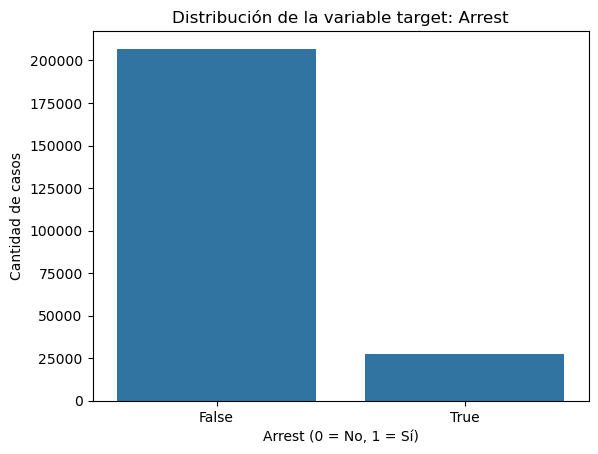

In [41]:
import seaborn as sns
import matplotlib.pyplot as plt

# Conteo de valores de la variable target
arrest_counts = new_df['Arrest'].value_counts()
print("Conteo de clases en 'Arrest':")
print(arrest_counts)
print("\nPorcentajes:")
print(arrest_counts / len(new_df) * 100)

# Visualización
sns.countplot(x='Arrest', data=new_df)
plt.title('Distribución de la variable target: Arrest')
plt.xlabel('Arrest (0 = No, 1 = Sí)')
plt.ylabel('Cantidad de casos')
plt.show()

In [42]:
# Para balancear utilizamos Oversampling para duplicar la clase minoritaria.
from sklearn.utils import resample

# Separar clases
df_majority = new_df[new_df['Arrest'] == False]
df_minority = new_df[new_df['Arrest'] == True]

# Aumentar la clase minoritaria para igualar el tamaño
df_minority_upsampled = resample(
    df_minority,
    replace=True,                      
    n_samples=len(df_majority),      
    random_state=42
)

# Combinar clases
df_balanced = pd.concat([df_majority, df_minority_upsampled])

# Verificar nuevo balance
print("Nuevo balance:")
print(df_balanced['Arrest'].value_counts(normalize=True) * 100)


Nuevo balance:
Arrest
False    50.0
True     50.0
Name: proportion, dtype: float64


### Conclusion:
- **En la distribucion de la variable tarjet notamos que existen muchos más datos de la clase False con respecto a la clase True. Si utilizaramos undersampling perderiamos información útil. Por eso, la mejor opción fue utilizar oversampling, duplicando asi la clase minoritaria para balancear**.

### Verificando algunos datos.

In [43]:
# Corrigiendo la columna periodo
def clasificar_periodo(hora):
    if 0 <= hora < 6:
        return 'madrugada'
    elif 6 <= hora < 12:
        return 'mañana'
    elif 12 <= hora < 18:
        return 'tarde'
    else:
        return 'noche'

df_balanced['periodo'] = df_balanced['hora'].apply(clasificar_periodo)

In [44]:
display(df_balanced.head())

,ID,Case Number,Date,Block,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,...,Updated On,Latitude,Longitude,Location,anio,mes,dia,hora,dia_semana,periodo
0,13024128,JG202134,2022-12-31 23:55:00,055XX W ADAMS ST,1477,WEAPONS VIOLATION,RECKLESS FIREARM DISCHARGE,RESIDENCE - YARD (FRONT / BACK),False,False,...,2023-11-15 15:41:31,41.878374,-87.762732,POINT (-87.762731975 41.878373984),2022,12,31,23,Saturday,noche
1,12938426,JG100085,2022-12-31 23:50:00,055XX W WASHINGTON BLVD,0486,BATTERY,DOMESTIC BATTERY SIMPLE,APARTMENT,False,True,...,2023-01-07 15:41:08,41.882257,-87.763744,POINT (-87.763744015 41.882256634),2022,12,31,23,Saturday,noche
2,12938337,JG100016,2022-12-31 23:50:00,014XX W LUNT AVE,0910,MOTOR VEHICLE THEFT,AUTOMOBILE,ALLEY,False,False,...,2023-01-07 15:41:08,42.009108,-87.666844,POINT (-87.666843608 42.009107852),2022,12,31,23,Saturday,noche
5,12938578,JG100071,2022-12-31 23:45:00,001XX E RANDOLPH ST,0460,BATTERY,SIMPLE,VEHICLE NON-COMMERCIAL,False,False,...,2023-01-07 15:41:08,41.884437,-87.624040,POINT (-87.624039818 41.884437037),2022,12,31,23,Saturday,noche
6,12938724,JG100582,2022-12-31 23:45:00,013XX W 112TH ST,0910,MOTOR VEHICLE THEFT,AUTOMOBILE,STREET,False,False,...,2023-01-07 15:41:08,41.690379,-87.655642,POINT (-87.655641646 41.690378914),2022,12,31,23,Saturday,noche


## Análisis y selección de features:
- **Implementar tests estadísticos para evaluar relaciones entre features**.
- **Realizar una selección de variables basándose en su relevancia y significancia**.
- **Justificar la elección de las variables seleccionadas**.
- **Crear nuevos features en caso de ser necesario. Justificar**.

In [45]:
from scipy.stats import chi2_contingency, ttest_ind
import pandas as pd

# Test Chi-cuadrado para categóricas
categorical_features = ['Primary Type', 'Location Description', 'Domestic', 'dia_semana', 'periodo']

print("Chi-cuadrado (variables categóricas vs Arrest):\n")
for feature in categorical_features:
    try:
        contingency = pd.crosstab(df_balanced[feature], df_balanced['Arrest'])
        chi2, p, dof, expected = chi2_contingency(contingency)
        print(f"{feature:25} -> p-value = {p:.4f} {'Relación significativa' if p < 0.05 else 'No significativa'}")
    except Exception as e:
        print(f"{feature:25} -> ERROR: {e}")

# T-test para numéricas
numeric_features = ['hora', 'anio', 'mes', 'dia']

print("\nT-test (medias de variables numéricas entre arrestos y no arrestos):\n")
for feature in numeric_features:
    try:
        group_arrest = df_balanced[df_balanced['Arrest'] == True][feature]
        group_no_arrest = df_balanced[df_balanced['Arrest'] == False][feature]
        t_stat, p_value = ttest_ind(group_arrest, group_no_arrest)
        print(f"{feature:10} -> p-value = {p_value:.4f} {'Diferencia significativa' if p_value < 0.05 else 'No significativa'}")
    except Exception as e:
        print(f"{feature:10} -> ERROR: {e}")

Chi-cuadrado (variables categóricas vs Arrest):

Primary Type              -> p-value = 0.0000 Relación significativa
Location Description      -> p-value = 0.0000 Relación significativa
Domestic                  -> p-value = 0.0000 Relación significativa
dia_semana                -> p-value = 0.0000 Relación significativa
periodo                   -> p-value = 0.0000 Relación significativa

T-test (medias de variables numéricas entre arrestos y no arrestos):

hora       -> p-value = 0.0000 Diferencia significativa
anio       -> p-value = nan No significativa


C:\Users\dmendoza\AppData\Local\anaconda3\Lib\site-packages\scipy\stats\_axis_nan_policy.py:531: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


mes        -> p-value = 0.0000 Diferencia significativa
dia        -> p-value = 0.0000 Diferencia significativa


La variables categoricas seleccionadas tiene una relacion significativa con Arrest. Conservar la variables numericas de hora, mes y dia.

In [46]:
# Método Filter: Correlación y Chi-Cuadrado (Confirmación)
# Evaluar la relacion estadistica entre cada feature y la variable tarjet Arrest
from scipy.stats import chi2_contingency

# Función para calcular correlación punto-biserial (para categóricas vs binario)
def point_biserial_corr(cat_feature, binary_target):
    contingency = pd.crosstab(cat_feature, binary_target)
    chi2, p, _, _ = chi2_contingency(contingency)
    cramers_v = np.sqrt(chi2 / (len(cat_feature) * (min(contingency.shape) - 1)))
    return cramers_v

# Calcular correlación para categóricas
results = {}
for feature in ['Primary Type', 'Location Description', 'Domestic', 'dia_semana', 'periodo']:
    cramers_v = point_biserial_corr(df_balanced[feature], df_balanced['Arrest'])
    results[feature] = cramers_v

# Mostrar resultados
correlation_df = pd.DataFrame.from_dict(results, orient='index', columns=['Cramers_V'])
print("Correlación (Cramér's V) con Arrest:\n", correlation_df.sort_values(by='Cramers_V', ascending=False))

Correlación (Cramér's V) con Arrest:
                       Cramers_V
Primary Type           0.564917
Location Description   0.247889
periodo                0.104941
Domestic               0.023267
dia_semana             0.020284


Observacion: los valores de Cramér's V (que van de 0 a 1) indican la fuerza de asociación entre cada feature categórica y Arrest. Para este caso existe una asociacion fuerte de Primary Type con Arrest.

Importancia de Features (Random Forest):
 Primary Type_encoded            0.612897
Location Description_encoded    0.244561
hora                            0.119824
Domestic                        0.022718
dtype: float64


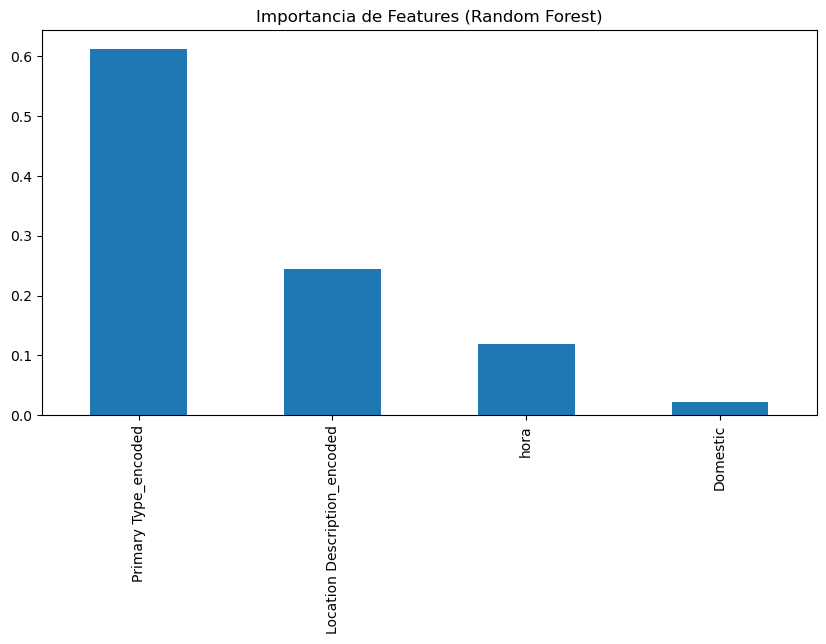

In [47]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder

# Codificar variables categóricas (requerido para Random Forest)
label_encoders = {}
X_encoded = df_balanced.copy()

# Codificar solo las features seleccionadas (tras Cramér's V + T-test)
features_to_encode = ['Primary Type', 'Location Description']
for col in features_to_encode:
    le = LabelEncoder()
    X_encoded[col + '_encoded'] = le.fit_transform(X_encoded[col])
    label_encoders[col] = le  # Guardar encoders para futuras transformaciones

# Definir features finales (numéricas + codificadas)
final_features = [
    'Primary Type_encoded', 
    'Location Description_encoded',
    'hora', 
    'Domestic'  # Aunque tiene bajo Cramér's V, la incluimos para comparar
]

X = X_encoded[final_features]
y = X_encoded['Arrest'].astype(int)

# Entrenar Random Forest
model = RandomForestClassifier(random_state=42, n_estimators=100)
model.fit(X, y)

# Importancia de features
importance = pd.Series(model.feature_importances_, index=final_features).sort_values(ascending=False)
print("Importancia de Features (Random Forest):\n", importance)

# Gráfico
importance.plot(kind='bar', figsize=(10, 5), title='Importancia de Features (Random Forest)')
plt.show()

## Conclusion:
**Después de aplicar análisis estadísticos (Chi-cuadrado, T-test, Cramér's V) y métodos de Machine Learning (Random Forest), hemos identificado las 3 features más relevantes para predecir si un crimen resultará en arresto (Arrest):**
- Primary Type (Variable categórica): mayor importancia en Random Forest (61.3%) y alta correlación (Cramér's V=0.56).
- Location Description (Variable categórica): segunda en importancia (24.5% en RF) y significancia estadística (Chi2).
- hora (Variable numerica): diferencias significativas (T-test) y aporte moderado en RF (12%).

## Transformación de variables:
- **Aplicar técnicas de conversión de variables, por ejemplo: codificación, discretización**.
- **Escalar y / o normalizar los features.**.

In [48]:
# Aplicando One Hot Encoding para Primary Type y Location Description.
df_encoded = pd.get_dummies(df_balanced[['Primary Type', 'Location Description', 'hora']], drop_first=True)
df_encoded.head()

,hora,Primary Type_ASSAULT,Primary Type_BATTERY,Primary Type_BURGLARY,Primary Type_CONCEALED CARRY LICENSE VIOLATION,Primary Type_CRIMINAL DAMAGE,Primary Type_CRIMINAL SEXUAL ASSAULT,Primary Type_CRIMINAL TRESPASS,Primary Type_DECEPTIVE PRACTICE,Primary Type_GAMBLING,...,Location Description_VACANT LOT / LAND,Location Description_VEHICLE - COMMERCIAL,Location Description_VEHICLE - COMMERCIAL: ENTERTAINMENT / PARTY BUS,Location Description_VEHICLE - COMMERCIAL: TROLLEY BUS,Location Description_VEHICLE - DELIVERY TRUCK,"Location Description_VEHICLE - OTHER RIDE SHARE SERVICE (LYFT, UBER, ETC.)",Location Description_VEHICLE NON-COMMERCIAL,Location Description_VESTIBULE,Location Description_WAREHOUSE,Location Description_YARD
0,23,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,23,False,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,23,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
5,23,False,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False
6,23,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [49]:
df_encoded['hora'] = df_encoded['hora'].astype(int)

# Normalizacion
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

# One Hot son booleanas (True/False), pasarlas a enteros (0/1)
df_encoded['hora'] = scaler.fit_transform(df_encoded[['hora']])

for col in df_encoded.columns:
    if df_encoded[col].dtype == bool:
        df_encoded[col] = df_encoded[col].astype(int)

df_encoded.head()

,hora,Primary Type_ASSAULT,Primary Type_BATTERY,Primary Type_BURGLARY,Primary Type_CONCEALED CARRY LICENSE VIOLATION,Primary Type_CRIMINAL DAMAGE,Primary Type_CRIMINAL SEXUAL ASSAULT,Primary Type_CRIMINAL TRESPASS,Primary Type_DECEPTIVE PRACTICE,Primary Type_GAMBLING,...,Location Description_VACANT LOT / LAND,Location Description_VEHICLE - COMMERCIAL,Location Description_VEHICLE - COMMERCIAL: ENTERTAINMENT / PARTY BUS,Location Description_VEHICLE - COMMERCIAL: TROLLEY BUS,Location Description_VEHICLE - DELIVERY TRUCK,"Location Description_VEHICLE - OTHER RIDE SHARE SERVICE (LYFT, UBER, ETC.)",Location Description_VEHICLE NON-COMMERCIAL,Location Description_VESTIBULE,Location Description_WAREHOUSE,Location Description_YARD
0,1.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1.0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,1.0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
6,1.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Conclusion:
**En esta etapa se aplicaron técnicas para preparar las variables relevantes para el modelado predictivo:**

- Codificación de variables categóricas: se utilizó One Hot Encoding para las variables categóricas Primary Type y Location Description, transformándolas en variables binarias, lo que facilita el uso de algoritmos de machine learning que requieren variables numéricas.
- Manejo de la variable numérica hora: la variable hora se mantuvo numérica, pero fue normalizada usando Min-Max Scaling para ajustar sus valores al rango [0, 1], evitando que su escala influyera de forma desproporcionada en el entrenamiento del modelo.
- Conversión de tipos: Se convirtieron las columnas binarias resultantes del One Hot Encoding de booleanas a enteros (0/1), asegurando compatibilidad con los algoritmos.

## Reducción de la dimensionalidad:
- **Implementar dos técnicas de reducción de la dimensionalidad. Comparar.**
- **Comparar el dataset original con el dataset reducido, evaluando las ventajas y
desventajas de la reducción.**
- **Analizar cómo la reducción de la dimensionalidad afecta la interpretación y el
rendimiento de futuros modelos predictivos.**

varianza explicada por cada componente: [0.15224075 0.09716499]


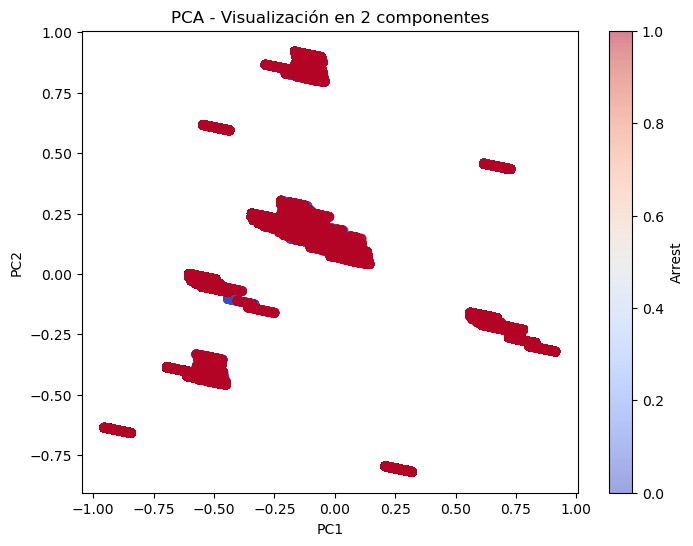

In [50]:
# Aplicando PCA
from sklearn.decomposition import PCA

# Aplicamos PCA para reducir dimensiones a 2 componentes
pca = PCA(n_components=2)
pca_result = pca.fit_transform(df_encoded)

print("varianza explicada por cada componente:", pca.explained_variance_ratio_)

import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
plt.scatter(pca_result[:,0], pca_result[:,1], c=df_balanced['Arrest'], cmap='coolwarm', alpha=0.5)
plt.colorbar(label='Arrest')
plt.title('PCA - Visualización en 2 componentes')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()


- La primera componente principal (PC1) explica aproximadamente el 15.2 % de la varianza del dataset original.
- La segunda componente (PC2) explica el 9.7 % adicional.
- PCA logra capturar una parte representativa de la información en solo 2 dimensiones, aunque no toda.

**Gráfico de Sedimentación (Scree Plot)**

Realizamos un gráfico de sedimentación para evaluar cuántos componentes principales sería ideal utilizar. En este caso, vemos que con unos 25 CP podemos explicar casi un 90% del problema.

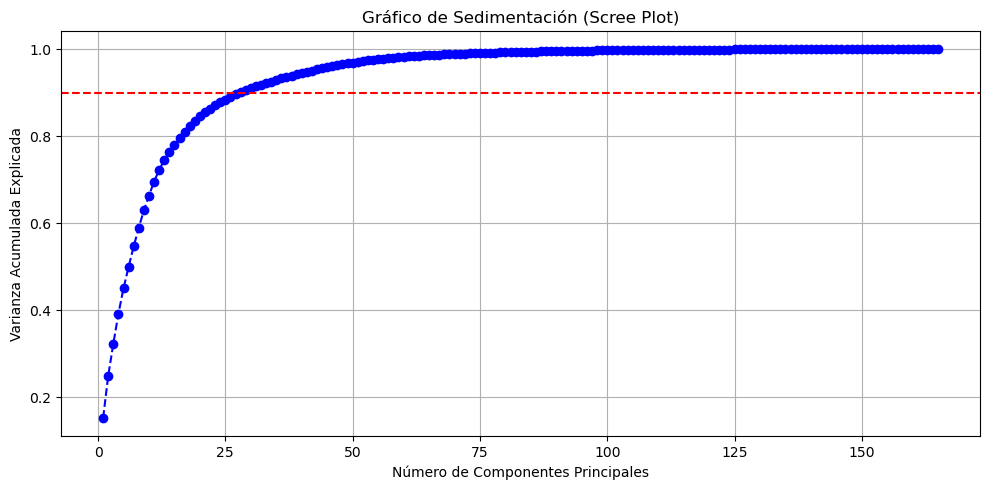

In [51]:
# Aplicamos PCA sin limitar el número de componentes
pca_full = PCA()
pca_full.fit(df_encoded)

# Gráfico de sedimentación
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(pca_full.explained_variance_ratio_) + 1),
         pca_full.explained_variance_ratio_.cumsum(),
         marker='o', linestyle='--', color='b')
plt.title('Gráfico de Sedimentación (Scree Plot)')
plt.xlabel('Número de Componentes Principales')
plt.ylabel('Varianza Acumulada Explicada')
plt.grid(True)
plt.axhline(y=0.9, color='r', linestyle='--', label='90% de varianza')  # línea de referencia del 90%
plt.tight_layout()
plt.show()


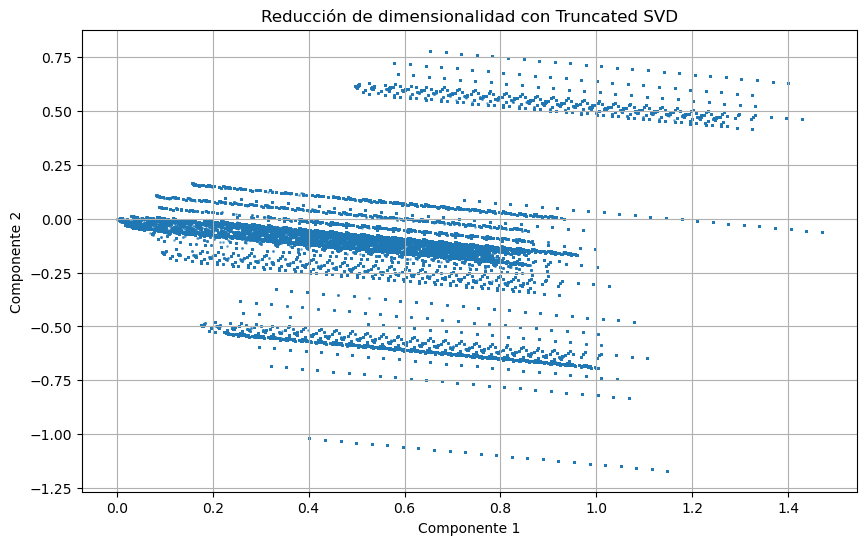

Varianza explicada por componente: [0.057212   0.14044464]
Varianza total explicada: 0.1976566417472182


In [52]:
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt

# Instanciar el modelo
svd = TruncatedSVD(n_components=2, random_state=42)

# Aplicar SVD al dataset transformado
svd_components = svd.fit_transform(df_encoded)

# Visualizar los componentes
plt.figure(figsize=(10, 6))
plt.scatter(svd_components[:, 0], svd_components[:, 1], s=1, alpha=0.5)
plt.title("Reducción de dimensionalidad con Truncated SVD")
plt.xlabel("Componente 1")
plt.ylabel("Componente 2")
plt.grid(True)
plt.show()

# Opcional: ver cuánto explica cada componente
print("Varianza explicada por componente:", svd.explained_variance_ratio_)
print("Varianza total explicada:", svd.explained_variance_ratio_.sum())


Comparacion:
Varianza explicada:
- PCA: 24.9% (sumando dos primeros PCs)
- Truncated SVD: 19.7% (dos primeros componentes)

Conclusion:
PCA explicó un poco más de varianza total que Truncated SVD con los primeros dos componentes, lo que sugiere que captura mejor la estructura principal del dataset. La reducción a 2 componentes (PCA o SVD) simplifica mucho los datos, pero solo explica entre el 20 y 25 porciento de la varianza, perdiendo mucho detalle.

### Comparación entre el dataset original y el dataset reducido

El dataset original contiene 165 variables (features), muchas de las cuales provienen de la codificación one-hot de variables categóricas como el tipo de crimen, la hora y la ubicación. Este número de dimensiones aumentó la complejidad del análisis y puede generar redundancia.

Al aplicar técnicas de reducción de dimensionalidad como **PCA** y **Truncated SVD**, logramos reducir la dimensionalidad del dataset a solo 2 componentes principales. Aunque esta reducción implica una pérdida de información.

### Ventajas de la reducción:
- Menor complejidad computacional en modelos posteriores.
- Mejora la visualización de los datos (graficos en 2D).
- Permite eliminar ruido o variables redundantes.

### Desventajas:
- Puede perderse información relevante si no se conserva suficiente varianza.


### Impacto de la reducción de dimensionalidad en la interpretación y el rendimiento de modelos

Reducir la dimensionalidad puede afectar el rendimiento de modelos de clasificación o predicción de distintas maneras.

- En modelos como regresión logística o árboles de decisión, una menor cantidad de variables reduce el riesgo de **overfitting**, especialmente si el número de instancias es limitado en relación al número de features.
- La reducción de la dimensionalidad **mejora la eficiencia y estabilidad del modelo**, pero puede ser menos transparente ya que cada CP mezcla un poco de todas las variables originales.
